In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# set random seed
np.random.seed(0)

# Data Processing

In [2]:
matches = pd.read_csv('data/matches.csv')
tournaments = pd.read_csv('data/tournaments.csv')
tournament_standings = pd.read_csv('data/tournament_standings.csv')
ratings = pd.read_csv('data/fifa_ranking-2022-10-06.csv')

In [3]:
matches['year'] = matches['tournament_id'].str.split('-').str[1].astype(int)
matches = matches[matches['year'] >= 1990]
tournament_standings['year'] = tournament_standings['tournament_id'].str.split('-').str[1].astype(int)
tournament_standings = tournament_standings[tournament_standings['year'] >= 1990].reset_index(drop=True)
tournaments = tournaments[tournaments['year'] >= 1990].reset_index(drop=True)


In [4]:
matches = matches.replace('West Germany', 'Germany')
tournaments = tournaments.replace('West Germany', 'Germany')
tournament_standings = tournament_standings.replace('West Germany', 'Germany')

In [5]:
matches.drop(['tournament_id', 'key_id', 'tournament_name', 
            'match_id', 'match_name', 'stadium_name', 
            'stadium_id', 'match_time', 'city_name', 'result',
            'score_penalties', 'match_date', 'home_team_id',
            'away_team_id', 'home_team_code', 'away_team_code',
            'group_name', 'replay', 'replayed'], axis=1, inplace=True)

tournaments = tournaments[['year', 'host_country', 'winner']]
tournament_standings = tournament_standings[['year', 'team_name', 'position']]
ratings.drop(['country_abrv', 'total_points', 'previous_points'], axis=1, inplace=True)

In [6]:
ratings['year'] = ratings['rank_date'].str.split('-').str[0].astype(int)
ratings.drop(['rank_date'], axis=1, inplace=True)
ratings.rename(columns={'country_full': 'team'}, inplace=True)

In [7]:
tournaments = tournament_standings.merge(tournaments, on=['year'], how='left').drop(['winner', 'host_country'], axis=1)

In [8]:
home_team_score_margin = matches.groupby('home_team_name')['home_team_score_margin']\
    .mean()\
    .reset_index()\
    .rename(columns={'home_team_name': 'team', 
    'home_team_score_margin': 'avg_score_margin'})
    
away_team_score_margin = matches.groupby('away_team_name')['away_team_score_margin']\
    .mean()\
    .reset_index()\
    .rename(columns={'away_team_name': 'team', 
            'away_team_score_margin': 'avg_score_margin'})

score_margin = pd.concat([home_team_score_margin, away_team_score_margin])
score_margin = score_margin.groupby('team')['avg_score_margin'].mean().reset_index()

In [9]:
tournaments = tournaments.rename(columns = {'team_name': 'team'})
ratings = ratings.merge(score_margin, on=['team'], how='left')

In [10]:
qualified = ['Qatar', 'Iran', 'South Korea', 'Saudi Arabia', 'Japan', 'Australia', 
            'Germany', 'Denmark', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 
            'England', 'Netherlands', 'Switzerland', 'Portugal', 'Poland', 'Wales', 'Brazil', 
            'Argentina', 'Ecuador', 'Uruguay', 'Ghana', 'Senegal', 'Tunisia', 'Morocco', 
            'Cameroon', 'Canada', 'USA', 'Mexico', 'Costa Rica']

In [11]:
data = tournaments.merge(ratings, on=['year', 'team'], how='right')
data = data[data['team'].isin(qualified)]


In [12]:
data['avg_score_margin'] = data['avg_score_margin'].fillna(data.groupby('team')['avg_score_margin'].transform('mean'))
data = data[data['year'].isin([1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022])]
data['confederation'] = data['confederation'].map({'UEFA': 0, 'CONMEBOL': 1, 'CAF': 2, 'AFC': 3, 'CONCACAF': 4, 'OFC': 5})

# Training Model: XGBOOST

In [13]:
test = data[data['year'] == 2022].drop('position', axis=1)
train = data[data['year'] < 2018]
valid = data[data['year'] == 2018]

In [14]:
train['position'] = train['position'].fillna(0)
train['avg_score_margin'] = train['avg_score_margin'].fillna(-1)

valid['position'] = valid['position'].fillna(0)
valid['avg_score_margin'] = valid['avg_score_margin'].fillna(-1)

In [15]:
model = XGBClassifier()
model.fit(train.drop(['team', 'year', 'position'], axis=1), train['position'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

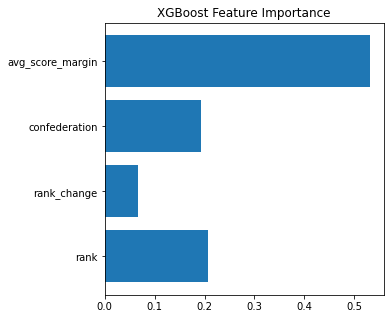

In [16]:
# plot xgboost feature importance as a barplot with feature names
feature_importance = model.feature_importances_
feature_names = train.drop(['team', 'year', 'position'], axis=1).columns
plt.figure(figsize=(5, 5))
plt.barh(feature_names, feature_importance)
plt.title('XGBoost Feature Importance')
plt.show()

# Evaluation

In [17]:
# evaluate predictions on training data
y_pred = model.predict(train.drop(['team', 'year', 'position'], axis=1))
accuracy = accuracy_score(train['position'], y_pred)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))

Train Accuracy: 95.87%


In [18]:
# evaluate predictions on validation data
y_pred = model.predict(valid.drop(['team', 'year', 'position'], axis=1))
accuracy = accuracy_score(valid['position'], y_pred)
print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))

Validation Accuracy: 80.56%


In [19]:
predictions = model.predict(valid.drop(['team', 'year', 'position'], axis=1))
probabilities = model.predict_proba(valid.drop(['team', 'year', 'position'], axis=1))

valid['position'] = predictions
valid['probabilities'] = probabilities.max(axis=1)

In [20]:
results_valid = valid.loc[:, ['team', 'position', 'probabilities']]

In [21]:
results_valid = results_valid.loc[results_valid['position'] != 0]\
    .groupby(['team', 'position'])['team', 'probabilities', 'position']\
    .apply(lambda x: x.nlargest(1, 'probabilities'))\
    .reset_index(drop=True)\
    .sort_values(['position', 'probabilities'], ascending=[True, False])

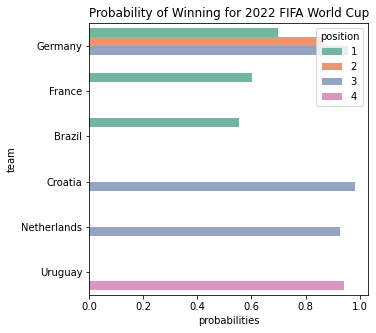

In [22]:
plt.figure(figsize=(5, 5))
sns.barplot(x='probabilities', y='team', data=results_valid, hue='position', palette="Set2")
plt.title('Probability of Winning for 2022 FIFA World Cup')
plt.show()

# 2022 Predictions

In [23]:
# retraining data on the whole dataset
train = data[data['year'] != 2022]
train['position'] = train['position'].fillna(0)
train['avg_score_margin'] = train['avg_score_margin'].fillna(-1)

model = XGBClassifier()
model.fit(train.drop(['team', 'year', 'position'], axis=1), train['position'])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [24]:
predictions = model.predict(test.drop(['team', 'year'], axis=1))
probabilities = model.predict_proba(test.drop(['team', 'year'], axis=1))

test['position'] = predictions
test['probabilities'] = probabilities.max(axis=1)
results = test.loc[:, ['team', 'position', 'probabilities']]

In [25]:
results = results.loc[results['position'] != 0]\
    .groupby(['team', 'position'])['team', 'probabilities', 'position']\
    .apply(lambda x: x.nlargest(1, 'probabilities'))\
    .reset_index(drop=True)\
    .sort_values(['position', 'probabilities'], ascending=[True, False])

In [26]:
results

,team,probabilities,position
1,Brazil,0.726757,1
4,Germany,0.977184,2
3,France,0.941651,2
2,Croatia,0.608594,2
0,Belgium,0.978476,3
5,Portugal,0.857341,4


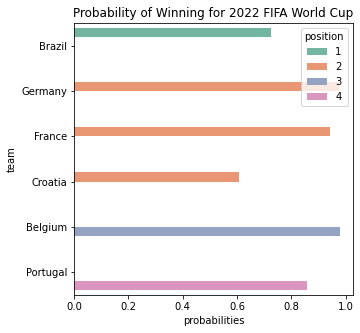

In [27]:
plt.figure(figsize=(5, 5))
sns.barplot(x='probabilities', y='team', data=results, hue='position', palette="Set2")
plt.title('Probability of Winning for 2022 FIFA World Cup')
plt.show()
